In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
%matplotlib inline

import pandas as pd
from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
from statsmodels.formula.api import ols, glm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import metrics

np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [65]:
sessions = [s for s in selected_009265.keys()]
sessions.sort()
sessions

['009265_hippoSIT_2023-02-24_09-53-26',
 '009265_hippoSIT_2023-02-24_17-22-46',
 '009265_hippoSIT_2023-02-27_10-18-32',
 '009265_hippoSIT_2023-02-27_15-33-46',
 '009265_hippoSIT_2023-02-28_09-16-50',
 '009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34',
 '009265_hippoSIT_2023-04-13_09-54-39',
 '009265_hippoSIT_2023-04-20_11-39-02']

## Based on AEP metrics

In [66]:
def build_AEP_AM(session, area, win_l_idx=0, win_r_idx=8):
    session_data = load_session_data(session)
    AEP_metrics_norm = session_data['AEP_metrics_norm']
    tgt_matrix       = session_data['tgt_matrix']

    # use only records with enough AEPs in target
    tgt_mx_filt = tgt_matrix[tgt_matrix[:, 3] - tgt_matrix[:, 2] >= win_r_idx]

    metric_names = ['P1', 'N1', 'P2', 'P3']  # ensure order
    AEP_resp_mx = np.zeros([len(tgt_mx_filt), (win_r_idx - win_l_idx)*len(metric_names)])
    for i, tgt_record in enumerate(tgt_mx_filt):
        AEP_mx = np.zeros([win_r_idx - win_l_idx, len(metric_names)])
        for j, AEP_rel_idx in enumerate(np.arange(win_l_idx, win_r_idx)):
            for k, m_name in enumerate(metric_names):
                AEP_mx[j, k] = AEP_metrics_norm[area][m_name][tgt_record[2] + AEP_rel_idx]
        AEP_resp_mx[i] = AEP_mx.flatten()
        
    # AEP flattened response matrix + labels (success/miss)
    return AEP_resp_mx, tgt_mx_filt[:, 4]

In [97]:
def get_LR_scores(AEP_mx, labels, iter_count=1000, shuffle=False, test_size=0.33):
    logisticRegr = LogisticRegression(max_iter=500)
    scores  = np.zeros(iter_count)
    conf_mx = np.zeros([iter_count, 2, 2])

    for i in range(iter_count):
        lbls = labels.copy()
        if shuffle:
            np.random.shuffle(lbls)
        
        # split train / test
        x_train, x_test, y_train, y_test = train_test_split(AEP_mx, lbls, test_size=test_size)
        if len(np.unique(y_train)) == 1 or len(np.unique(y_test)) == 1:
            continue
        
        # fit logistic regression
        logisticRegr.fit(x_train, y_train)
        predictions = logisticRegr.predict(x_test)
        scores[i]   = logisticRegr.score(x_test, y_test)
        conf_mx[i]  = metrics.confusion_matrix(y_test, predictions)
        
    return scores, conf_mx

In [76]:
session = sessions[8]
area = 'A1'
win_l_idx = -8  # how many AEPs before target to take into account
win_r_idx = 2  # how many AEPs in target to take into account

AEP_resp_mx, labels = build_AEP_AM(session, area, win_l_idx, win_r_idx)

scores, conf_mx = get_LR_scores(AEP_resp_mx, labels)
scores_shuf, conf_mx_shuf = get_LR_scores(AEP_resp_mx, labels, shuffle=True)

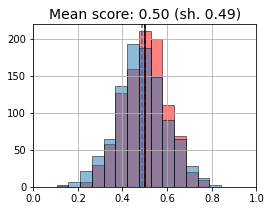

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(scores, bins=np.linspace(0, 1, 20), edgecolor='black', color='red', alpha=0.5)
ax.hist(scores_shuf, bins=np.linspace(0, 1, 20), edgecolor='black', color='tab:blue', alpha=0.5)
ax.axvline(scores.mean(), ls='--', color='red')
ax.axvline(scores_shuf.mean(), ls='--', color='tab:blue')
ax.axvline(0.5, color='black')
ax.set_title('Mean score: %.2f (sh. %.2f)' % (scores.mean(), scores_shuf.mean()), fontsize=14)
ax.set_xlim(0, 1)
ax.grid()

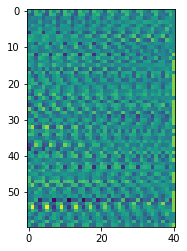

In [78]:
plt.imshow(np.column_stack([AEP_resp_mx, labels]))

## Based on population activity

In [132]:
session = sessions[5]
area = 'A1'

session_data = load_session_data(session)
tl          = session_data['tl']
tgt_matrix  = session_data['tgt_matrix']
spike_times = session_data['spike_times']
unit_names  = session_data['unit_names']
h5_file = session_data['h5_file']

In [133]:
offset    = 7.25
bin_count = 30

In [134]:
tgt_units       = []
idxs_succ       = np.where(tgt_matrix[:, 4] == 1)[0]
tgt_succ_times  = tl[tgt_matrix[idxs_succ][:, 0]][:, 0]

for unit_name in unit_names:
    with h5py.File(h5_file, 'r') as f:
        shuffled = np.array(f['units'][unit_name]['psth_shuffled_tgt_onset'])
    
    # based on success trials
    strain = spike_times[unit_name]
    bins, counts_enter = get_spike_counts(strain, tgt_succ_times, hw=offset, bin_count=bin_count)
    zero_bin_idx = len(bins[bins < 0]) - 1

    if counts_enter[zero_bin_idx] > shuffled[zero_bin_idx][3]: #or \
        #counts_enter[zero_bin_idx + 1] > shuffled[zero_bin_idx + 1][3]:
        tgt_units.append(unit_name)
        
print("%d units selected" % len(tgt_units))

8 units selected


In [135]:
# try to include only selective units (tgt onset, or lowering FR in tgt)

In [136]:
# build activity matrix
sel_units = unit_names
sel_units = tgt_units

bin_size = 0.4  # sec
step = 0.1  # sec 
t_start, t_end = int(tl[0][0]), int(tl[-1][0])
bc = int((t_end - t_start) / bin_size) + 1
exp_coef = round(bin_size/step)
bins = np.linspace(t_start, t_end, bc)
unit_act_matrix = np.zeros([len(sel_units), len(bins) * exp_coef])

for i, unit in enumerate(sel_units):
    spikes = spike_times[unit]
    for offset in range(exp_coef):
        bins = np.linspace(t_start + offset*step, t_end + offset*step, bc)
        vals, _ = np.histogram(spikes, bins=bins)
        idxs = np.arange(offset, (bc - 1) * exp_coef, exp_coef)
        unit_act_matrix[i][idxs] = vals
        
for i, unit_data in enumerate(unit_act_matrix):
    unit_act_matrix[i] = stats.zscore(unit_data)
    
unit_act_matrix.shape  # 10 Hz

(8, 23992)

In [137]:
win_l_idx = -3  # seconds before target
win_r_idx = 2   # seconds after target
psth_matrix  = np.zeros([len(tgt_matrix), int((win_r_idx - win_l_idx)/step)])

for i, tgt_record in enumerate(tgt_matrix):
    am_idx = int(tgt_record[0]*step)
    pop_response = unit_act_matrix[:, am_idx + int(win_l_idx/step):am_idx + int(win_r_idx/step)].sum(axis=0)
    if len(pop_response) == psth_matrix.shape[1]:
        psth_matrix[i] = pop_response
    else:
        print('shape mismatch in %s' % i)

shape mismatch in 0


In [138]:
non_zero_idxs = np.where(psth_matrix.any(axis=1))[0]

data   = psth_matrix[non_zero_idxs]
labels = tgt_matrix[:, 4][non_zero_idxs]

scores, conf_mx = get_LR_scores(data, labels, iter_count=1000)
scores_shuf, conf_mx_shuf = get_LR_scores(data, labels, iter_count=1000, shuffle=True)

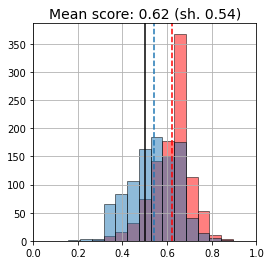

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.hist(scores, bins=np.linspace(0, 1, 20), edgecolor='black', color='red', alpha=0.5)
ax.hist(scores_shuf, bins=np.linspace(0, 1, 20), edgecolor='black', color='tab:blue', alpha=0.5)
ax.axvline(scores.mean(), ls='--', color='red')
ax.axvline(scores_shuf.mean(), ls='--', color='tab:blue')
ax.axvline(0.5, color='black')
ax.set_title('Mean score: %.2f (sh. %.2f)' % (scores.mean(), scores_shuf.mean()), fontsize=14)
ax.set_xlim(0, 1)
ax.grid()

## TODO: Based on the full AEP shape